In [2]:
import pandas as pd
import numpy as np

In [152]:
df = pd.concat([pd.read_csv('DataFiles/RegularSeasonDetailedResults.csv'),
           pd.read_csv('DataFiles/NCAATourneyDetailedResults.csv')]).reset_index(drop=True)
df = df.sort_values(by=['Season','DayNum'])
elo_scores = pd.read_csv('elo_scores.csv',index_col=0)
elo_scores = elo_scores[elo_scores['Season'] >= 2003]
elo_scores = elo_scores.sort_values(by=['Season','DayNum']).reset_index(drop=True)
df = pd.merge(df,elo_scores)
rankings = pd.read_csv('rankings.csv',index_col=0)
df = pd.merge(df,rankings)

In [153]:
## Possessions
df['WPos'] = 0.96*(df['WFGA']+df['WTO']+0.475*df['WFTA']-df['WOR'])
df['LPos'] = 0.96*(df['LFGA']+df['LTO']+0.475*df['LFTA']-df['LOR'])

## Offensive Rating
df['WOffR'] = df['WScore']/df['WPos']
df['LOffR'] = df['LScore']/df['LPos']

## Defensive Rating
df['WDefR'] = df['LScore']/df['WPos']
df['LDefR'] = df['WScore']/df['LPos']

## Net Rating
df['WNetR'] = df['WOffR'] - df['WDefR']
df['LNetR'] = df['LOffR'] - df['LDefR']

## Assist Ratio
df['WAstR'] = df['WAst']/(df['WFGA']+0.475*df['WFTA']+df['WAst']+df['WTO'])
df['LAstR'] = df['LAst']/(df['LFGA']+0.475*df['LFTA']+df['LAst']+df['LTO'])

## Turnover Ratio
df['WTOR'] = df['WTO']/(df['WFGA']+0.475*df['WFTA']+df['WAst']+df['WTO'])
df['LTOR'] = df['LTO']/(df['LFGA']+0.475*df['LFTA']+df['LAst']+df['LTO'])

## True Shooting Percentage
df['WTSP'] = 0.5*df['WScore']/(df['WFGA']+0.475*df['WFTA']) 
df['LTSP'] = 0.5*df['LScore']/(df['LFGA']+0.475*df['LFTA']) 

## Effective Field Goal Percentage
df['WEFGP'] = (df['WFGM']+0.5*df['WFGM3'])/df['WFGA']
df['LEFGP'] = (df['LFGM']+0.5*df['LFGM3'])/df['LFGA']

## Free Throw rate
df['WFTR'] = df['WFTA']/df['WFGA']
df['LFTR'] = df['LFTA']/df['LFGA']

## Off Rebound Percentage
df['WORP'] = df['WOR']/(df['WOR']+df['LOR'])
df['LORP'] = df['LOR']/(df['LOR']+df['WOR'])

## Def Rebound Percentage
df['WDRP'] = df['WDR']/(df['WDR']+df['LDR'])
df['LDRP'] = df['LDR']/(df['LDR']+df['WDR'])

## Total Rebound Percentage
df['WTRP'] = (df['WDR']+df['WOR'])/(df['WDR']+df['WOR']+df['LDR']+df['LOR'])
df['LTRP'] = (df['LDR']+df['LOR'])/(df['LDR']+df['LOR']+df['WDR']+df['WOR'])

## Economy
df['WEcon'] = (df['WAst'] + df['WStl'] - df['WTO'])*40/(40+df['NumOT']*5)
df['LEcon'] = (df['LAst'] + df['LStl'] - df['LTO'])*40/(40+df['NumOT']*5)

# Modified Tendex
df['WTendex'] = (df['WScore']+(df['WOR']+df['WDR'])+1.25*df['WAst']+1.25*df['WStl']+df['WBlk']\
                -df['WTO'] - (df['WFGA']-df['WFGM']) - (df['WFTA']-df['WFGM'])/2)/(40+df['NumOT']*5)/df['WPos']
df['LTendex'] = (df['LScore']+(df['LOR']+df['LDR'])+1.25*df['LAst']+1.25*df['LStl']+df['LBlk']\
                -df['LTO'] - (df['LFGA']-df['LFGM']) - (df['LFTA']-df['LFGM'])/2)/(40+df['NumOT']*5)/df['LPos']

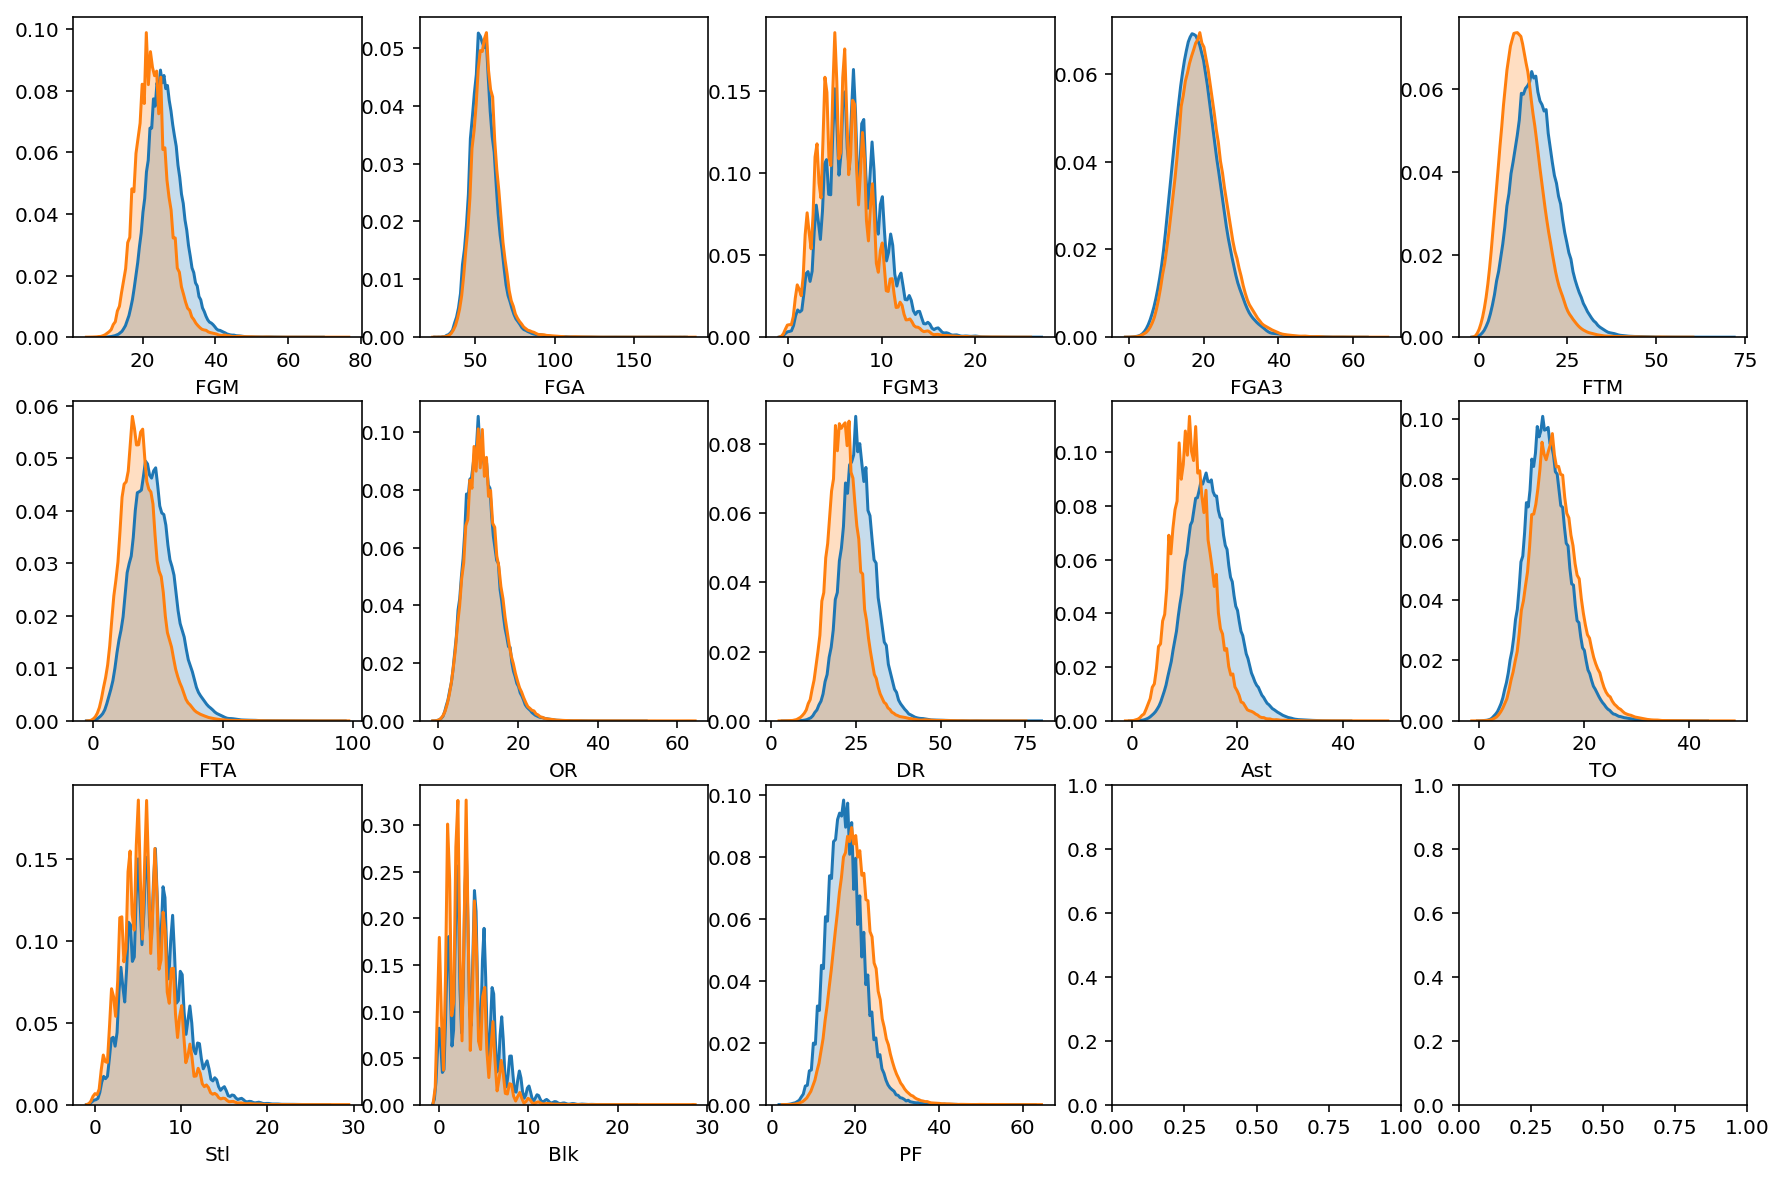

In [154]:
import seaborn as sns
import matplotlib.pyplot as plt
stats = ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']
fig,ax = plt.subplots(nrows=3,ncols=5,figsize=(15,10))
for i,s in enumerate(stats):
    sns.kdeplot(data=df['W'+s]/(40/(40+df['NumOT']*5)),shade=True,ax=ax.flat[i])
    sns.kdeplot(data=df['L'+s]/(40/(40+df['NumOT']*5)),shade=True,ax=ax.flat[i])
    ax.flat[i].set_xlabel(s)

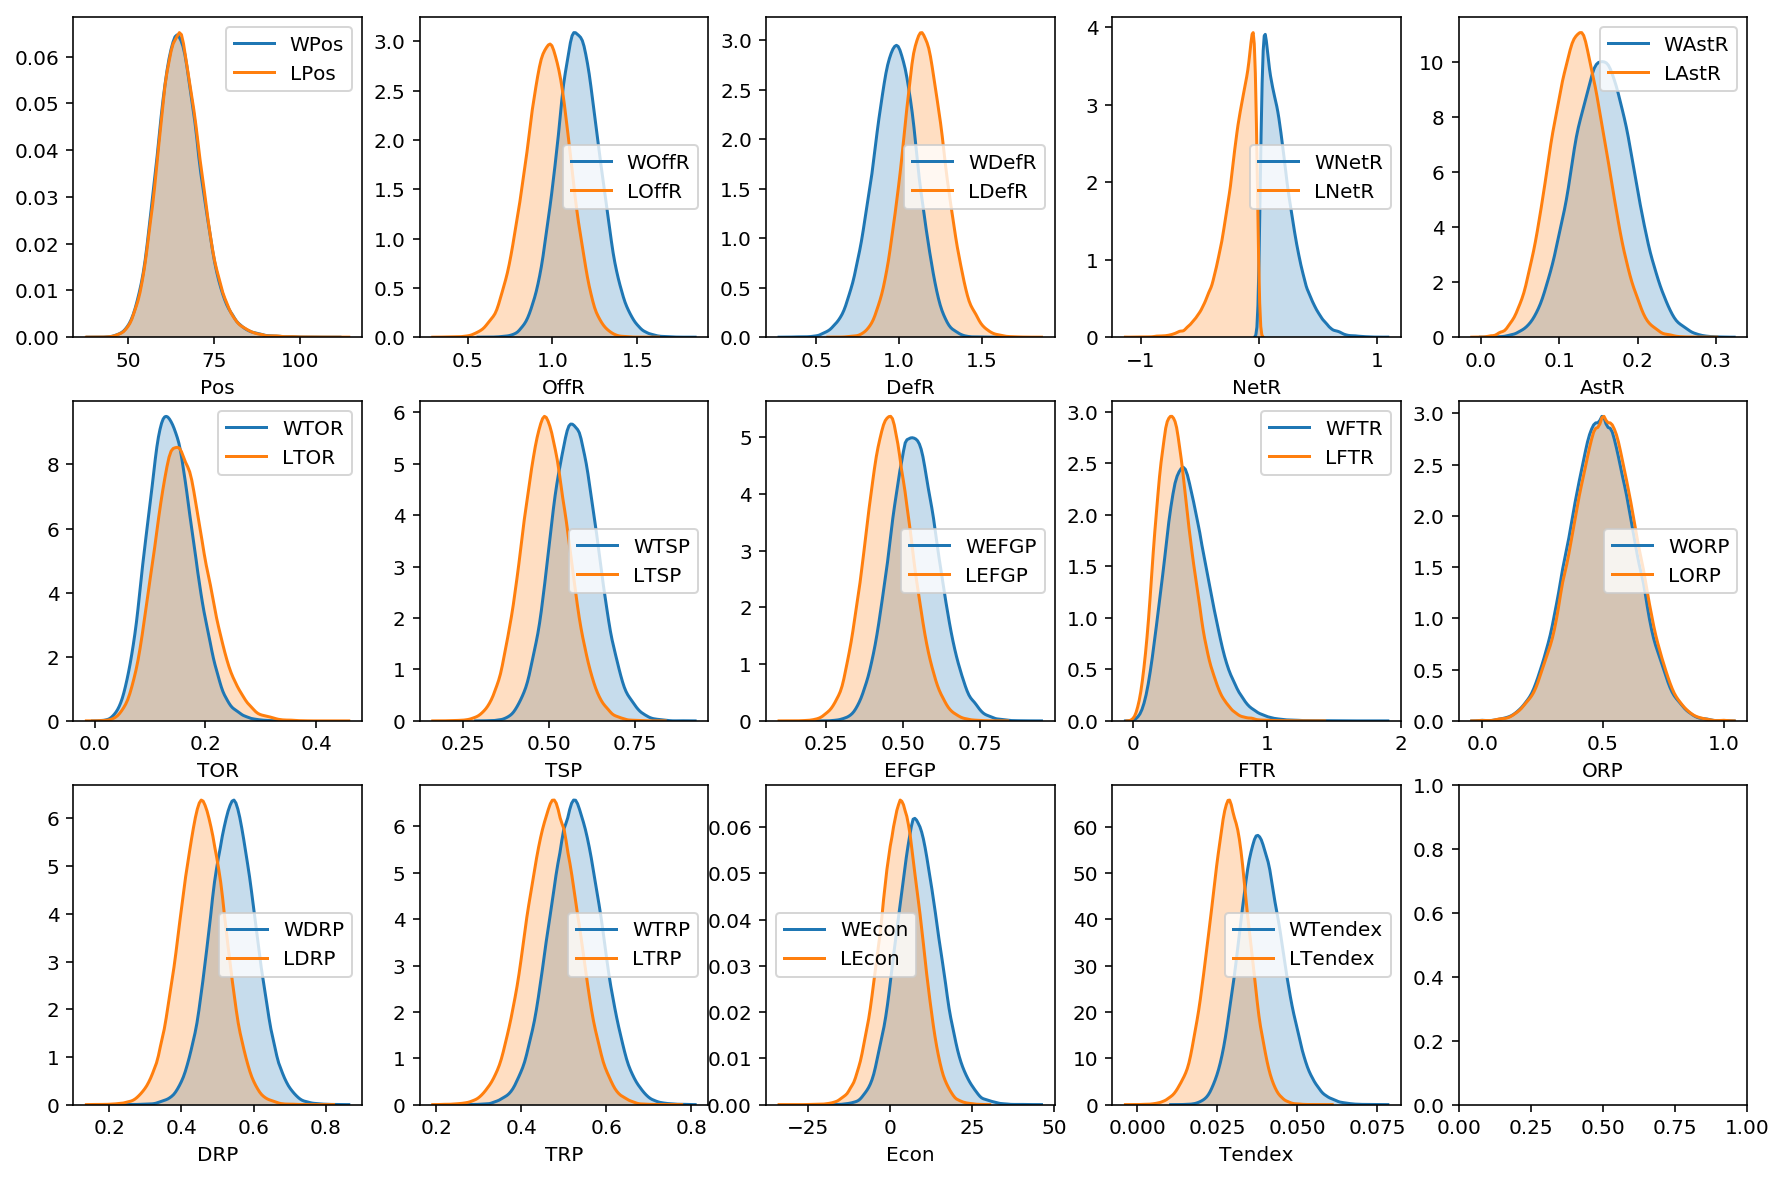

In [155]:
import seaborn as sns
import matplotlib.pyplot as plt
adv_stats = ['Pos','OffR','DefR','NetR','AstR','TOR','TSP','EFGP','FTR','ORP','DRP','TRP','Econ','Tendex']
fig,ax = plt.subplots(nrows=3,ncols=5,figsize=(15,10))
for i,s in enumerate(adv_stats):
    sns.kdeplot(data=df['W'+s],shade=True,ax=ax.flat[i])
    sns.kdeplot(data=df['L'+s],shade=True,ax=ax.flat[i])
    ax.flat[i].set_xlabel(s)

In [176]:
## Here are the statistics we want to create rolling means for
#to_roll = ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']
to_roll = adv_stats[1:]

## We're going to create a dictionary of dictionaries that store the rolling means for each team.
##    The outer dictionary is for each individual team.
##    The inner dictionaries contain each statistic's rolling mean.
averages = dict()
for ID in df['WTeamID'].unique():
    averages[ID] = dict()
    team = df[(df['WTeamID'] == ID) | (df['LTeamID'] == ID)]
    for r in to_roll:
        ## Here we apply a function that selects the correct statistic based on whether the team is W or L.
        ## Method chaining: roll over last 4 games, take the mean, shift one down so that we don't include
        ##     the statistic for the game that is being predicted, backward fill for NaN
        averages[ID][r] = team.apply(lambda x: x['W%s' % r] if x['WTeamID'] == ID else x['L%s' % r],axis=1).\
            rolling(4).mean().shift(1).bfill()

In [177]:
df_roll = df[['WTeamID','LTeamID','Season','DayNum','WElo_after','LElo_after','Wrank','Lrank']]
for r in to_roll:
    df_roll['W'+r] = df_roll.apply(lambda row: averages[row['WTeamID']][r].loc[row.name],axis=1)
    df_roll['L'+r] = df_roll.apply(lambda row: averages[row['LTeamID']][r].loc[row.name],axis=1)

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [178]:
## shuffle the data by re-sampling all of it
df_shuffle = df_roll.sample(frac=1,random_state=123)

## split the shuffled data in two
orig = df_shuffle.iloc[:len(df)//2,:].reset_index(drop=True)
rev = df_shuffle.iloc[len(df)//2:,:].reset_index(drop=True)

for r in to_roll:
    orig[r] = orig['W'+r] - orig['L'+r]
    rev[r] = rev['L'+r] - rev['W'+r]
    
orig['Elo_Diff'] = orig['WElo_after'] - orig['LElo_after'] 
rev['Elo_Diff'] = rev['LElo_after'] - rev['WElo_after']

orig['Rank_Diff'] = orig['Wrank'] - orig['Lrank']
rev['Rank_Diff'] = rev['Lrank'] - rev['Wrank']

orig = orig[orig.columns]
rev = rev[orig.columns]
    
orig['Result'] = 1
rev['Result'] = 0

df_target = pd.concat([orig,rev])
df_target['Elo_Prob'] = df_target['Elo_Diff'].apply(lambda x: 1 / (10**(-x/400) + 1))
df_target = df_target.sort_values(by=['Season','DayNum']).reset_index(drop=True)

In [179]:
df_target.head()

,WTeamID,LTeamID,Season,DayNum,WElo_after,LElo_after,Wrank,Lrank,WOffR,LOffR,...,FTR,ORP,DRP,TRP,Econ,Tendex,Elo_Diff,Rank_Diff,Result,Elo_Prob
0,1272,1393,2003,10,1667.542934,1595.123079,66.764706,76.823529,1.066490,1.135146,...,-0.064315,0.034689,0.011019,0.020446,-6.194444,-0.003946,72.419855,-10.058824,1,0.602737
1,1104,1328,2003,10,1748.857994,1844.100636,14.157895,22.157895,1.066191,1.194948,...,-0.136777,0.096748,-0.019176,0.024615,8.250000,0.006819,95.242642,8.000000,0,0.633732
2,1266,1437,2003,11,1745.312953,1645.271705,29.210526,42.411765,1.242934,1.119122,...,-0.101348,-0.052785,0.037064,-0.006169,8.000000,0.008597,100.041248,-13.201238,1,0.640120
3,1458,1186,2003,11,1688.326778,1499.750667,31.588235,133.000000,1.237542,1.082847,...,-0.042186,0.125544,0.023682,0.057239,4.500000,0.006404,188.576111,-101.411765,1,0.747539
4,1296,1457,2003,11,1448.588387,1461.246706,179.764706,231.176471,0.901374,0.951293,...,-0.195248,0.173755,-0.022906,0.038828,4.250000,0.001742,12.658319,51.411765,0,0.518209


In [180]:
predictors = ['AstR','TSP','OffR','DefR','NetR','Tendex','DRP','TRP','Elo_Prob','Rank_Diff']
X = df_target[predictors]
y = df_target['Result']

In [181]:
from sklearn.model_selection import train_test_split

In [182]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=321)

In [183]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

SS = StandardScaler()
LR = LogisticRegression(random_state=444)
PL = Pipeline(steps = [('ss',SS),('LR',LR)])
param_grid = {'LR__penalty':['l1','l2'],'LR__C':np.logspace(-4,4,9)}
grid = GridSearchCV(PL,param_grid=param_grid,cv=5,refit=True)
grid.fit(X_train,y_train)
clf = grid.best_estimator_
print('Train score: %0.4f' % clf.score(X_train,y_train))
print('Test score:  %0.4f' % clf.score(X_test,y_test))

Train score: 0.7881
Test score:  0.7852


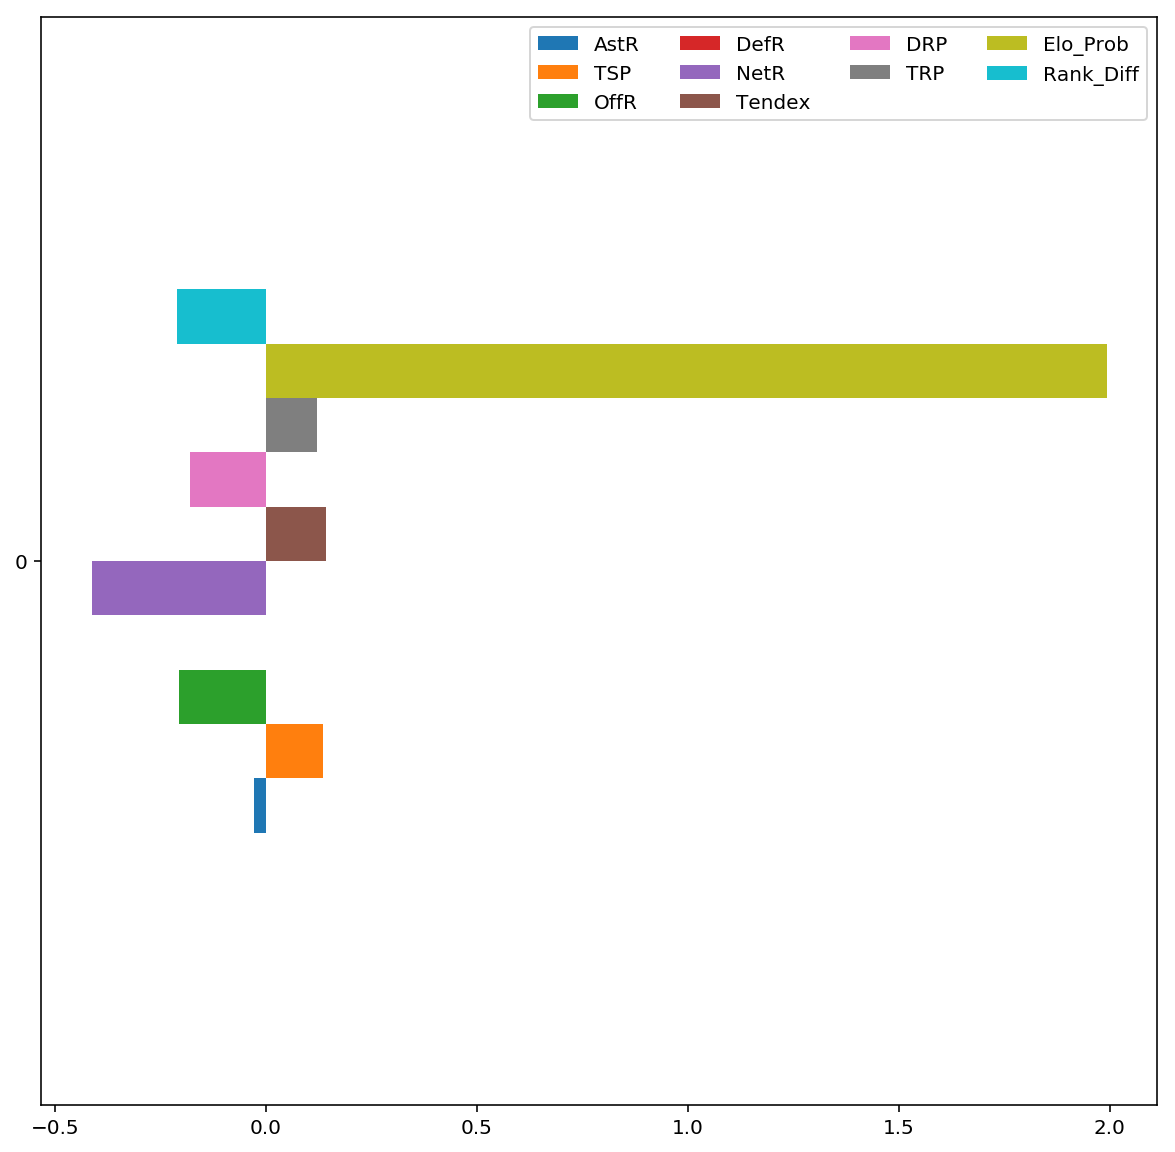

In [184]:
pd.DataFrame(clf.named_steps['LR'].coef_,columns=X.columns).plot(kind='barh',figsize=(10,10)).legend(ncol=4)

In [185]:
seeds = pd.read_csv('DataFiles/NCAATourneySeeds.csv')

In [186]:
submit = []
full = []
for s in range(2014,2019):
    stats = []
    subset = df_roll[(df_roll['Season'] == s) & (df_roll['DayNum'] <= 133)]
    for t in seeds[seeds['Season'] == s]['TeamID']:
        row = {'TeamID':t}
        team_stats = subset[(subset['WTeamID'] == t) | (subset['LTeamID'] == t)]
        team_stats = team_stats.loc[team_stats['DayNum'].idxmax()]
        if team_stats['WTeamID'] == t:
            for r in to_roll:
                row[r] = team_stats['W'+r]
            row['Elo'] = team_stats['WElo_after']
            row['Rank'] = team_stats['Wrank']
        else:
            for r in to_roll:
                row[r] = team_stats['L'+r]
            row['Elo'] = team_stats['LElo_after']
            row['Rank'] = team_stats['Lrank']
        stats.append(row)
    stats = pd.DataFrame(stats).sort_values('TeamID').set_index('TeamID')
    
    pairings = []
    for i in range(len(stats)):
        teamA = stats.iloc[i]
        for j in range(i+1,len(stats)):
            teamB = stats.iloc[j]
            x = teamA - teamB
            x['TeamA'] = teamA.name
            x['TeamB'] = teamB.name
            pairings.append(x)
    
    pairings = pd.DataFrame(pairings)
    
    pairings.columns = pairings.columns.str.replace('Rank','Rank_Diff')
    pairings.columns = pairings.columns.str.replace('Elo','Elo_Diff')
    pairings['Elo_Prob'] = pairings['Elo_Diff'].apply(lambda x: 1 / (10**(-x/400) + 1))
    
    full.append(pairings)
    
    Z = pairings[predictors]
    pairings['Pred'] = clf.predict_proba(Z)[:,1]
    
    pairings['ID'] = pairings.apply(lambda row: '%d_%d_%d' % (s,row['TeamA'],row['TeamB']),axis=1)
    pairings['Season'] = s
    submit.append(pairings[['ID','Pred']])
    print('Done with season %d' % s)

submit = pd.concat(submit).set_index('ID')
full = pd.concat(full)

## validation
tourney = df_roll[(df_roll['DayNum'] > 133) & (df_roll['Season'] >= 2014)]
for i,game in tourney.iterrows():
    season = game['Season']
    teamW = game['WTeamID']
    teamL = game['LTeamID']
    teamA = min(teamW,teamL)
    teamB = max(teamW,teamL)
    p = full[(full['TeamA'] == teamA) & (full['TeamB'] == teamB) & (full['Season'] == season)]['Pred'].values[0]
    if teamA == teamL:
        p = 1 - p
    tourney.at[i,'Pred'] = p
logloss = -np.log(tourney['Pred']).mean()
print('LogLoss = %0.4f' % logloss)

Done with season 2014
Done with season 2015
Done with season 2016
Done with season 2017
Done with season 2018


/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


LogLoss = 0.5632


In [187]:
stamp = pd.Timestamp.now()
filename = 'submission_%d-%d-%d_%d:%d.csv' % (stamp.year,stamp.month,stamp.day,stamp.hour,stamp.minute)
message = 'Logistic Regression, with predictors: ' + ','.join(predictors) + ' stats = rolling mean of previous 4 games' 
print(filename)
print(message)

submission_2019-3-16_18:19.csv
Logistic Regression, with predictors: AstR,TSP,OffR,DefR,NetR,Tendex,DRP,TRP,Elo_Prob,Rank_Diff stats = rolling mean of previous 4 games


In [188]:
import os
submit.to_csv(filename)
os.system('kaggle competitions submit -c mens-machine-learning-competition-2019 -f %s -m "%s"' % (filename,message))
print('Submission Complete!')

Submission Complete!
